In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [3]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [4]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _cxt2str, _item2str, _s
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils_wab'): from model_utils_wab import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000038
utils ... done 0:00:00.003085
child_utils ... Loading tokenizer ... done 0:00:08.868318
done 0:00:12.266886
tasks ... done 0:00:00.002156
model_utils_wab ... done 0:00:08.097105
weight_analysis ... done 0:00:00.000031


In [5]:
torch.set_grad_enabled(False);

In [6]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [7]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', #'EleutherAI/gpt-j-6B',
                   'EleutherAI/gpt-neox-20b/cpu', #'EleutherAI/gpt-neox-20b'
                  ]#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:1]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 0
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 7; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

EleutherAI/gpt-j-6B/cpu ... done 0:05:01.500409


In [8]:
model_name = gpt_model_names[0]
# model_name = engines[-1]
model, tokenizer = models[model_name]

In [45]:
1

1

In [9]:
blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim

# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# es = [we]
# for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
# model.es = es
# weBTAs = [es[i].T @ es[i] for i in range(2)]
# model.weBTAs = weBTAs

In [ ]:
# device = torch.device('cuda:7')#wab
# _ = clone_model_to(model, device)

In [24]:
# def result2dict(result): return {k: v for k, v in result.__dict__.items() if k not in ['task', 'data_tuples']}  # 
# with gzip.open(f'results/results-genders_of_persons-types_of_things.pkl.gz', 'wb') as f:
#     pickle.dump({k: result2dict(r) for k, r in results.items()}, f)
# with gzip.open(f'results.pkl.gz', 'rb') as f: results = pickle.load(f)

NameError: name 'results' is not defined

In [48]:
# res_key = keys[0]; res_key
# fpath = f'results/{res_key}_attn_attrs.npz'
# np.savez_compressed(fpath, *dump_attn_attrs_to_arrays(root, result.data_tuples))

NameError: name 'keys' is not defined

In [344]:
# _root = deepcopy(root)
# def fn(node): node.data = asdict(node.data)
# traverse_tree(_root, fn, include_dummy=True)
# pickle.dump(_root, gzip.open(f'results/{res_key}_tree.pkl.gz', 'wb'))

In [10]:
tasks = [
    (lambda: [TreeSet(genders_of_persons).use('equal'), TreeSet(types_of_things).use('equal')], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {wrap_noun(i[1])}", f"The {i[1]} is {i[0]}'s"]), lambda q, _: f'{q}', " likes"
    ),
#     (lambda: [TreeSet(types_of_characters).use('child'), TreeSet(types_of_things).use('child')], partial(MlM_gen, cxt_sample_fn=enumerate_sample, query=1),
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {i[1]}", f"{the_(i[1])} is {i[0]}'s"]), lambda q, _: f"{q}", " likes"
#     ),
    (lambda: [TreeSet(genders_of_persons).use('child'), TreeSet(types_of_things).use('child')], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {i[1]}", f"{the_(i[1])} is {i[0]}'s"]), lambda q, _: f"{q}", " likes"
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [TreeSet(genders_of_persons).use('equal'), TreeSet(countries_of_cities).use('equal')], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} likes {i[1]}', f'{i[1]} attracts {i[0]}']), lambda q, _: f'{q} wants to go', ' to'
    ), # t: 19-12 >> 16-10 = 12-7
    (lambda: [TreeSet(genders_of_persons).use('equal'), TreeSet(countries_of_cities).use('child')], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} likes {i[1]}', f'{i[1]} attracts {i[0]}']), lambda q, _: f'{q} wants to go', ' to'
    ), # t: 19-12 >> 16-10 = 12-7
#     (lambda: [TreeSet(genders_of_persons).use('equal'), TreeSet(capabilities_of_things).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {wrap_noun(i[1])}", f"The {i[1]} is {i[0]}'s"]), lambda q, _: f'{q} likes', ' the'
#     ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), TreeSet(capabilities_of_things).use('child')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {wrap_noun(i[1])}", f"The {i[1]} is {i[0]}'s"]), lambda q, _: f'{q}', ' can'
#     ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{i[1].capitalize()} is {i[0]}"]), lambda q, _: f"Yes, {q} looks", " like"
#     ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), SymSet(person_adjs).use('opposite')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{i[1].capitalize()} is {i[0]}"]), lambda q, _: f"Um, {q} looks", " like"
#     ), # t: 16-14, somewhat 14-7 # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f"So {q}'s arrival time", ' is'
#     ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('prev')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f'So {q} arrived just', ' after'
#     ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('next')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f'So {q} arrived just', ' before'
#     ),
]

In [48]:
r.data_tuples[0][-1].attn_attr.keys()

odict_keys(['', '22-40 attn/candidates', '17-28 attn/candidates', '19-1 attn/candidates', '26-57 attn/candidates', '23-54 attn/candidates', '22-40 attn/candidates > 15-38', '22-40 attn/candidates > 14-39', '22-40 attn/candidates > 10-52', '17-28 attn/candidates > 15-38', '17-28 attn/candidates > 14-39', '17-28 attn/candidates > 11-50', '17-28 attn/candidates > 11-35', '17-28 attn/candidates > 14-30', '17-28 attn/candidates > 15-0', '19-1 attn/candidates > 14-39', '19-1 attn/candidates > 15-0', '22-40 attn/candidates > 19-29', '22-40 attn/candidates > 11-m', '22-40 attn/candidates > 21-60'])

In [45]:
node = r.root.children[10]#.children[1]
node.name

'@5 22-40 69 B->A0 99/78 attn'

In [ ]:
plot_attn_attrs(r.data_tuples[:], model, tokenizer, node, topi=[3,4,6], attn_patterns=['B->B'], k_shot=k_shot, mix=True)

In [199]:
for l in range(35, L): print(l, show_predictions_by_data_tuples(model, tokenizer, r.data_tuples, k_shot, to_layer=l, verbose=False))

35 (0.5464575067162514, 0.8194444444444444)
36 (0.45821835473179817, 0.8333333333333334)
37 (0.3822524305433035, 0.8888888888888888)
38 (0.3553805500268936, 0.8888888888888888)
39 (0.3521486185491085, 0.9027777777777778)
40 (0.3169629741460085, 0.875)
41 (0.327828467823565, 0.8472222222222222)
42 (0.33170338813215494, 0.875)
43 (0.34491169452667236, 0.8888888888888888)


In [11]:
results = {}

In [12]:
# key = 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]' # 18-5  11-4,13-11 B->A0+ 10-11?
key = 'MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]'
# key = 'MlM_gen[cxt_sample_fn=enumerate_sample,query=1][types_of_characters.TreeSet.equal,types_of_characters.TreeSet.equal][cxt_len=3,abstract]'

In [61]:
del results[key]

In [73]:
all_examples, texts, all_bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                        for i in range(batch_size)])

In [79]:
all_examples[0][1]

[[('Jason', 'Bangkok'), ('Dorothy', 'Madrid'), ('Sarah', 'Saint Petersburg')],
 'Jason',
 (['Jason', 'Dorothy', 'Sarah'],
  ['Jason', 'Dorothy', 'Sarah'],
  ['Bangkok', 'Madrid', 'Saint Petersburg'],
  ['Bangkok', 'Madrid', 'Saint Petersburg']),
 ('Jason', 'Bangkok', 'Bangkok')]

In [82]:
any(s in texts[0][24:] for s in ['dangerous'])

False

In [83]:
predict(model, tokenizer, texts[0], all_examples[0],
                k_shot=k_shot, bos_token=all_bos_tokens[0], trim=False, verbose=verbose)

TypeError: expected Tensor as element 0 in argument 0, but got tuple

 Ġbaseball 0.182 {'Ġto': 0.234, 'Ġbaseball': 0.182, 'Ġthe': 0.048} 	 Kevin has baseball. Karen has green. Donna has plum. Kevin likes baseball *Ġbaseball:14.466 Ġgreen:11.726 Ġplum:11.277
*Ġbeetle 0.729 {'Ġbeetle': 0.729, 'Ċ': 0.121, 'Ġbug': 0.015} 	 Daniel has beetle. Jennifer has goat. Linda has peach. Daniel likes beetle *Ġbeetle:17.852 Ġgoat:10.239 Ġpeach:10.308
*Ġbasketball 0.618 {'Ġbasketball': 0.618, 'Ġgorilla': 0.097, 'Ċ': 0.08} 	 Barbara has gorilla. Karen has strawberries. William has basketball. William likes basketball Ġgorilla:15.809 Ġstrawberries:9.739 *Ġbasketball:17.661
*Ġsmartphone 0.711 {'Ġsmartphone': 0.711, 'Ġvodka': 0.062, 'Ġplum': 0.059} 	 Steven has plum. Edward has vodka. Sharon has smartphone. Sharon likes smartphone Ġplum:15.130 Ġvodka:15.185 *Ġsmartphone:17.625
*Ġbeer 0.853 {'Ġbeer': 0.853, 'Ġrevolver': 0.12, 'Ġgun': 0.002} 	 Jennifer has iPad. Jeff has beer. Sandra has revolver. Jeff likes beer ĠiPad:12.278 *Ġbeer:19.780 Ġrevolver:17.822
*Ġpants 0.601 {'Ġpan

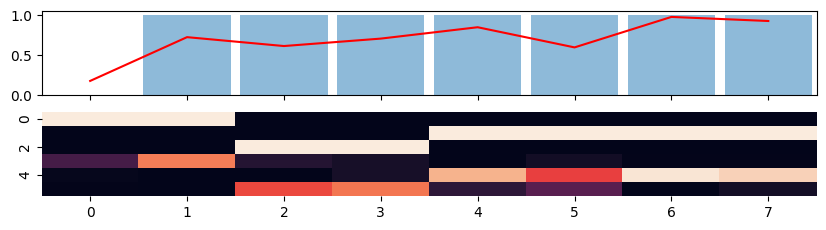

 Ġbaseball 0.166 {'Ġto': 0.239, 'Ġbaseball': 0.166, 'Ġthe': 0.025} 	 David has monkey. Brian has motorcycle. Sarah has baseball. Sarah likes baseball Ġmonkey:11.453 Ġmotorcycle:9.057 *Ġbaseball:14.474
*Ġspaghetti 0.753 {'Ġspaghetti': 0.753, 'Ċ': 0.094, 'Ġpasta': 0.023} 	 Richard has pistol. Daniel has fox. Sandra has spaghetti. Sandra likes spaghetti Ġpistol:7.724 Ġfox:11.494 *Ġspaghetti:17.658
*ĠT 0.536 {'ĠT': 0.536, 'Ġlaptop': 0.243, 'Ċ': 0.087} 	 Christopher has horse. Nancy has T-shirt. Kevin has laptop. Nancy likes T-shirt Ġhorse:11.555 *ĠT:17.081 Ġlaptop:16.293
*Ġbeetle 0.607 {'Ġbeetle': 0.607, 'Ġrifle': 0.279, 'ĠT': 0.021} 	 Patricia has peach. Jeff has beetle. Nancy has rifle. Jeff likes beetle Ġpeach:14.289 *Ġbeetle:18.054 Ġrifle:17.278
*Ġcannon 0.668 {'Ġcannon': 0.668, 'Ġwater': 0.181, 'Ġpizza': 0.09} 	 Paul has cannon. Mary has watermelon. Karen has pizza. Paul likes cannon *Ġcannon:18.782 Ġwater:17.477 Ġpizza:16.782
*Ġgorilla 0.974 {'Ġgorilla': 0.974, 'Ġmonkey': 0.003, 'Ċ':

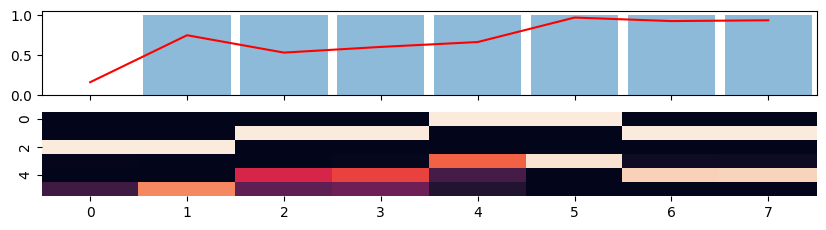

*Ġbaseball 0.248 {'Ġbaseball': 0.248, 'Ġto': 0.177, 'Ġthe': 0.042} 	 Jason has baseball. Carol has white. Lisa has purple. Jason likes baseball *Ġbaseball:15.289 Ġwhite:13.044 Ġpurple:13.083
*Ġpizza 0.854 {'Ġpizza': 0.854, 'Ċ': 0.021, 'Ġgun': 0.015} 	 Thomas has pizza. Helen has gun. Linda has deer. Thomas likes pizza *Ġpizza:18.306 Ġgun:14.252 Ġdeer:13.819
 Ġelephant 0.059 {'Ġbasketball': 0.444, 'Ċ': 0.164, 'Ġdeer': 0.097} 	 Jeff has basketball. Christopher has costume. Linda has elephant. Linda likes elephant Ġbasketball:17.077 Ġcostume:13.949 *Ġelephant:15.065
 Ġblack 0.055 {'Ġsoda': 0.906, 'Ġblack': 0.055, 'Ċ': 0.005} 	 Michelle has soda. Joseph has black. Donna has blackberry. Joseph likes black Ġsoda:19.793 *Ġblack:16.996 *Ġblack:16.996
*Ġlaptop 0.887 {'Ġlaptop': 0.887, 'Ġblue': 0.057, 'Ġblack': 0.011} 	 Anthony has blue. Betty has laptop. Donald has jeans. Betty likes laptop Ġblue:16.544 *Ġlaptop:19.294 Ġjeans:13.093
*Ġjeans 0.664 {'Ġjeans': 0.664, 'Ġblue': 0.074, 'Ġdenim': 0.05

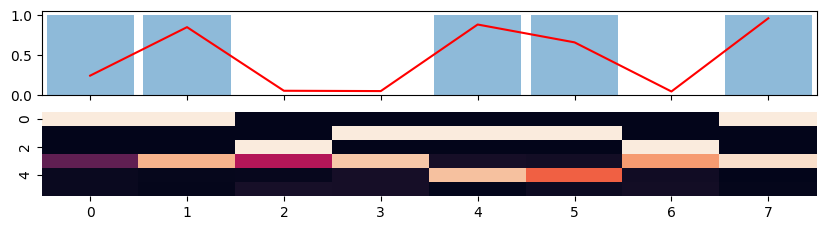

 Ġbeetle 0.069 {'Ġto': 0.221, 'Ġbeetle': 0.069, 'Ġbasketball': 0.033} 	 Sharon has basketball. Nancy has green. Christopher has beetle. Christopher likes beetle Ġbasketball:12.715 Ġgreen:11.829 *Ġbeetle:13.460
*Ġrifle 0.825 {'Ġrifle': 0.825, 'Ġto': 0.014, 'Ġgun': 0.009} 	 Christopher has iPad. James has burger. Sarah has rifle. Sarah likes rifle ĠiPad:8.352 Ġburger:12.630 *Ġrifle:17.429
 Ġpurple 0.152 {'Ġguitar': 0.482, 'Ġpurple': 0.152, 'ĠJeep': 0.112} 	 Barbara has purple. Joseph has Jeep. Mark has guitar. Barbara likes purple *Ġpurple:15.589 ĠJeep:15.281 Ġguitar:16.744
 Ġburger 0.122 {'Ġpurple': 0.551, 'Ġbasketball': 0.253, 'Ġburger': 0.122} 	 Kenneth has grapes. Donna has burger. Anthony has basketball. Donna likes burger Ġgrapes:12.249 *Ġburger:16.969 Ġbasketball:17.701
*Ġbus 0.822 {'Ġbus': 0.822, 'Ġmosquito': 0.038, 'Ġburger': 0.03} 	 Richard has bus. Maria has phone. Sharon has mosquito. Richard likes bus *Ġbus:18.466 Ġphone:14.551 Ġmosquito:15.391
 Ġred 0.194 {'Ġk': 0.414, 'Ġre

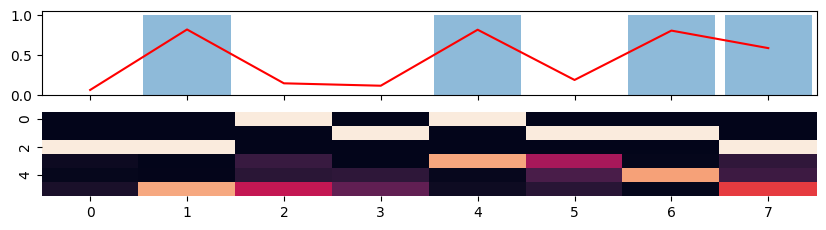

(0.6643258221447468, 0.8)

In [105]:
show_predictions_by_data_tuples(model, tokenizer, r.data_tuples, k_shot)

In [110]:
L

28

In [17]:
256*16

4096

In [18]:
nrows, k_shot = 16 // 2, 7 // 2; cxt_len = 3; save_results = True
batch_size = 8 // 2; verbose = False #not save_results or batch_size <= 8
rel0_kwargs_list = [{'skip_inv_f': True},{'skip_inv_f': False}]#[:1]
rel1_kwargs_list = [{'x_f': None, 'y_f': None, 'skip_inv_f': True}, {'x_f': _s, 'y_f': a_, 'skip_inv_f': True},
                    {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}]#[:1]
for task,        rel0_kwargs,     rel1_kwargs, do_swap_qa, do_negate, do_rm_local_hop, do_rm_query, rev_item2str in product(
#     tasks[1:2],rel0_kwargs_list,rel1_kwargs_list,[False,], [False,],  [True,],        [False,],    [False,]):
    tasks[1:2],rel0_kwargs_list,rel1_kwargs_list,[False,True],[False,], [False,],     [False,],   [False,True]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_kwargs=rel0_kwargs, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_local_hop=do_rm_local_hop, do_rm_query=do_rm_query)
    task = transform_task(task, **trans_args)
    if task is None: print('task is None! skip.'); continue
    res_key = f'{task2str(task)}[{args2str(args)}]'# + composed_heads2str(model)
    if key is not None and res_key != key: continue
    if not validate_args(task, args, trans_args): print('invalid args! skip.'); continue
#     if has_attribution_results(res_key): continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    r = results[res_key] if save_results and res_key in results else None
    r = generate_and_predict_batch(model, tokenizer, task, nrows, k_shot, batch_size,
                                        trim=False, result=r, verbose=verbose, **args)
    if save_results: results[res_key] = r
    if not save_results or getattr(r, 'mean_acc', 0) < 0.45: continue
        
# #     load_attribution_results(r, res_key)
    if True or r.root is None: r.root = add_node(None, layer=L, label_type='labels')
    r.root = attribute_tree_on(r.data_tuples, model, r.root, 1, topk=10, k_shot=k_shot, device='cpu', verbose=True)
#     with Timer('save_attribution_results'): save_attribution_results(r, res_key)
#     r.data_tuples = [dt[:-1] + [trim_outputs(dt[-1])] for dt in r.data_tuples] # to save mem. data_tuple is list!


== MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3] == rel0_kwargs=(skip_inv_f),rel1_kwargs=(skip_inv_f)
Kevin has baseball. Karen has green. Donna has plum. Kevin likes baseball
Daniel has beetle. Jennifer has goat. Linda has peach. Daniel likes beetle
Barbara has gorilla. Karen has strawberries. William has basketball. William likes basketball
attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:06.397781
In attribute_tree: attribute_step stage2  ... d.top_heads [(16, 7), (20, 8), (21, 13), (16, 0), (18, 5), (13, 7), (24, 10), (22, 9), (19, 0), (19, 13)]
output torch.Size([4, 10, 135, 256])
model.wos torch.Size([10, 256, 4096])
output torch.Size([4, 10, 137, 256])
model.wos torch.Size([10, 256, 4096])
output torch.Size([4, 10, 133, 256])
model.wos torch.Size([10, 256, 4096])
output torch.Size([4, 10, 134, 256])
model.wos torch.Size([10, 256, 4096])
done 0:00:02.693071
get ap_scores ... done 0:00:00.067129
get attr_ap_scores ... done 0

In [44]:
1

1

In [36]:
print_tree(r.root)

 ┌@[0,1,2,3,4,5,7,8,9] 16-7,20-8,21-13,16-0,18-5,13-7,22-9,19-0 38,19-13 30 B->A0 75
 ├@[6] 24-10 unk 0
 ├@0 16-7 100 B->A0 92/39 attn:B->~<s>
 ├@1 20-8 92 B->A0 90/30 attn:B->~<s>
 ├@2 21-13 84 B->A0 84/28 attn:B->~<s>
 ├@3 16-0 83 B->A0 94/40 attn:B->~<s>
 ├@4 18-5 81 B->A0 95/40 attn:B->~<s>
 ├@5 13-7 49 B->A0 88/42 attn:B->~<s>
 ├@7 22-9 40 B->A0 69/16 attn:B->~<s>
 ┤
 ├@17 14-6 17 B->A0/63 attn:B->~<s>
 ├@473 20-0 -63 B->A0/58 attn:B->~<s>
 │                      ┌@:9 16-7,16-0,21-13,18-5,14-6 36,20-8 29,13-7 24,17-9 23,21-8 15 B->A0 73
 │                      ├@[9] 8-m 12 B->B 10
 │                      ├@0 16-7 100 B->A0 89/39 attn:B->~<s>
 └@6 24-10 45 B->B 63/73┤
                        ├@1 16-0 66 B->A0 92/40 attn:B->~<s>
                        ├@2 21-13 46 B->A0 73/28 attn:B->~<s>
                        └@3 18-5 41 B->A0 90/40 attn:B->~<s>


In [43]:
r.root.children[-1].children[0].name

'@:9 16-7,16-0,21-13,18-5,14-6 36,20-8 29,13-7 24,17-9 23,21-8 15 B->A0 73'

In [34]:
r.root.children[0].data.top_heads

In [176]:
a = OrderedDict((key, get_x(key, r.data_tuples[0][-1], attr_heads=None, to_layer=28)) for key in ['mlp_mask', 'embed_mask', 'head_mask'])

In [ ]:
o.hidden_states[0]

In [203]:
model.transformer.ln_f

LayerNorm((4096,), eps=1e-05, elementwise_affine=True)

In [142]:
getattr(r.data_tuples[0][-1], 'logits_mask', None)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [147]:
get_x('attn_weights',r.data_tuples[0][-1],to_layer=28)

TypeError: 'NoneType' object is not iterable

In [167]:
r.data_tuples[0][-1].sum_output

AttributeError: 'Outputs' object has no attribute 'sum_output'

In [169]:
len(model.transformer.h)#[0].attn.num_heads

28

In [197]:
r.data_tuples[0][-1].attn_outs[0].size()

torch.Size([1, 16, 135, 256])

In [199]:
a['head_mask'][:,0].size()

torch.Size([1, 16])

In [150]:
r.root.data.layer

28

In [157]:
r.data.label_type

AttributeError: 'Result' object has no attribute 'data'

In [119]:
test = add_node(None, layer=L, label_type='labels')

In [125]:
test.data.layer

28

In [127]:
len(model.transformer.h)

28

In [128]:
max(test.data.layer) if isinstance(test.data.layer, Iterable) else test.data.layer

28

In [129]:
isinstance(test.data.layer, Iterable)

False

In [111]:
add_node(None, layer=L, label_type='labels') is None

False

In [116]:
node2key(r.root)

''

In [53]:
args2str(args)

'cxt_len=3,rev_item2str'

In [51]:
task2str(task)

'MlM_gen[countries_of_cities.TreeSet.child[x_f=_s,y_f=a_],genders_of_persons.TreeSet.equal]'

In [54]:
res_key

'MlM_gen[countries_of_cities.TreeSet.child[x_f=_s,y_f=a_],genders_of_persons.TreeSet.equal][cxt_len=3,rev_item2str]'

In [36]:
key = 'MlM_gen(genders_of_persons.TreeSet.child(skip_inv_f), types_of_things.TreeSet.child(skip_inv_f)) (cxt_len=3)'
result = results[key]; print_tree(result.root)

NameError: name 'results' is not defined

In [29]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc:.3f}")

MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3]: 0.296, 0.917
MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3,rev_item2str]: 1.237, 0.569
MlM_gen[types_of_things.TreeSet.equal,genders_of_persons.TreeSet.equal][cxt_len=3]: 1.466, 0.458
MlM_gen[types_of_things.TreeSet.equal,genders_of_persons.TreeSet.equal][cxt_len=3,rev_item2str]: 0.671, 0.722
MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal[x_f=_s,y_f=a_]][cxt_len=3]: 0.650, 0.833
MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal[x_f=_s,y_f=a_]][cxt_len=3,rev_item2str]: 1.830, 0.486
MlM_gen[types_of_things.TreeSet.equal[x_f=_s,y_f=a_],genders_of_persons.TreeSet.equal][cxt_len=3]: 1.263, 0.569
MlM_gen[types_of_things.TreeSet.equal[x_f=_s,y_f=a_],genders_of_persons.TreeSet.equal][cxt_len=3,rev_item2str]: 0.731, 0.708
MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.child[x_f=_s,y_f=a_]][cxt_len=3]: 2.357, 0.458


In [ ]:
key = 'MlM_gen(types_of_things.TreeSet.child, genders_of_persons.TreeSet.child) (cxt_len=3)'
result = results[key]; show_predictions_by_result(tokenizer, result, k_shot)

In [ ]:
nrows, k_shot = 16, 7; cxt_len=3; save_results = True
batch_size = 8; verbose = not save_results or batch_size <= 8
for task, replace_rel0, replace_rel1, do_swap_qa, do_negate, do_rm_local_hop, do_rm_query, rev_item2str in product(
    tasks[2:3], [0,  ], [0,     ],   [False,],[False,],[False,],[False,],[False,]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(replace_rel0=replace_rel0, replace_rel1=replace_rel1, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_local_hop=do_rm_local_hop, do_rm_query=do_rm_query)
    task = transform_task(task, **trans_args)
    if task is None: continue
    res_key = f"{task2str(task)} ({args2str(args)})" + composed_heads2str(model)
#     if not validate_args(task, args, trans_args): print('invalid args! skip.'); continue
#     if save_results and key is not None and res_key != key: continue
    if verbose: print(f'\n== {res_key} == {args2str(trans_args)}')
    if save_results and res_key in results:
        assert results[res_key].trans_args == trans_args, f'{res_key} {args2str(results[res_key].trans_args)} != {args2str(trans_args)}'
        result = results[res_key]; data_tuples = result.data_tuples
    else:
        all_examples, texts, all_bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                                for i in range(batch_size)])
        result = Result(task, trans_args, args, all_examples, texts)
        for text in texts: print('\n'.join(text.split('\n')[:3]))

        data_tuples, eval_results = zip(*[predict(model, tokenizer, text, examples,
            k_shot=k_shot, bos_token=bos_tokens, verbose=verbose)
            for text, examples, bos_tokens in zip(texts, all_examples, all_bos_tokens)
            if True or any(s in text[24:] for s in ['dangerous'])])
        result.data_tuples = data_tuples
        loss, acc, *_ = zip(*eval_results)
        result.mean_loss, result.mean_acc = np.array(loss).mean(), np.array(join_lists(acc)).mean()
        if verbose: print(result.mean_loss, result.mean_acc)
        if save_results: results[res_key] = result
    if not save_results: continue

#     for node_name in ['node']:
#         node = getattr(result, node_name, None)
#         if node is None: node = result.node = result.root = add_node(node, label_type=node_name.replace('node', 'labels'))
#         node.data.attr = mr(attribute_step)(data_tuples[:], model, node)
#     node.data.scores = {ap: mr(get_head_matching_scores)(data_tuples, ap, k_shot=k_shot)
#         for ap in attn_patterns_by_step.get(node.data.step, [])} if 'g2c' not in res_key else None

In [146]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}") # codex

MlM_gen(genders_of_persons.TreeSet.child, types_of_things.TreeSet.equal) (cxt_len=3): 1.395, 0.5277777777777778
MlM_gen(genders_of_persons.TreeSet.child, nouns.things.wrap_noun.TreeSet.child) (cxt_len=3): 2.519, 0.4027777777777778
MlM_gen(genders_of_persons.TreeSet.child, things.TreeSet.equal) (cxt_len=3): 1.395, 0.5277777777777778
MlM_gen(genders_of_persons.TreeSet.child, things.TreeSet.child) (cxt_len=3): 1.395, 0.5277777777777778


In [18]:
device = torch.device('cuda:0')
_ = clone_model_to(model, device)
data_tuples_gpu = data_tuples_to(data_tuples, device)

In [31]:
print_tree(root)  # cpu

          ┌[0] @:6 24-10,21-13,22-5,19-15,21-14,19-m
          ├[0] 11-12 B->Q] argmax_attn┐
          │                           └[1] 8-1 B->A]
          │                           ┌[1] 11-12 B->Q]
          ├[0] 13-7 B->A0] argmax_attn┤
          │                           └[1] 12-10 B->A]
 [-1] root┤
          │                                  ┌[1] 11-12 B->Q]
          ├[0] @7 16-7 32% B->A0] argmax_attn┤
          │                                  ├[1] 12-10 B->A]
          │                                  └[1] 13-13 B->A]
          ├[0] @0 24-10 100% B->B argmax_attn
          └[0] @1 21-13 68% B->A0] argmax_attn


In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.child, types_of_things.TreeSet.equal) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=True)

In [ ]:
for data_tuple in data_tuples[:3]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 13, 7, attn_patterns=['bos->ans0]'], k_shot=0, plot_attr=False)

In [160]:
node = node.parent

In [164]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2,3,4])#layer=11, head=12, attn_pattern='bos->query]', label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.child, types_of_things.TreeSet.equal) (cxt_len=3)
Maria has gray. Dorothy has a cat. Christopher has a revolver. The boy likes revolver
                 ┌[0] 13-2 argmax_attn_labels┐
                 │                           └[1] top[0, 1] 12-10,8-1┐
                 │                                                   └[2] top[0] 1-7
 [-1] root labels┤
                 │                           ┌[1] top[0, 1, 2, 3] 11-12,12-10,9-14,9-5
                 ├[0] 13-7 argmax_attn_labels┤
                 │                           ├[1] top[2] 9-14┐
                 │                           │               └[2] top[0, 1] 8-7,6-2
                 │                           └[1] top[1] 12-10┐
                 │                                            └[2] top[0, 1] 8-7,0-mlp
                 │                            ┌[1] top[0, 1, 2] 0-mlp,9-14,8-1
                 └[0] 11-12 argmax_attn_labels┤
                                              └[

In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.child) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:3]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 13, 7, attn_patterns=['bos->ans0]'], k_shot=0, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=False)

In [112]:
node = result.root

In [117]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2])#, attn_pattern='bos->query]', label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.child) (cxt_len=3)
Nancy has blueberries. Mary has a wolf. Jennifer has wine. Mary likes animal
                 ┌[0] 11-12 argmax_attn_labels┐
                 │                            └*[1] top[0, 1, 2] 0-mlp,9-5,10-8...
                 │                                  ┌[1] top[0, 1, 2, 3, 4, 5, 6] 19-mlp,14-9,16-mlp,8-1,13-13,17-mlp,12-10
                 ├[0] top[2] 21-5 argmax_attn_labels┤
                 │                                  └[1] top[3, 4, 6] 8-1,13-13,12-10┐
                 │                                                                   └[2] top[0, 1] 3-12,5-12
 [-1] root labels┤
                 │                                  ┌[1] top[0, 1, 2, 3, 4, 5] 14-9,0-mlp,8-1,13-13,12-10,9-14
                 ├[0] top[3] 15-8 argmax_attn_labels┤
                 │                                  ├[1] top[2, 3, 4, 5] 8-1,13-13,12-10,9-14┐
                 │                                  │

In [367]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])#attn_pattern='bos->ans0]', label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.child) (cxt_len=3)
                 ┌[0] 11-12 argmax_attn_labels
 [-1] root labels┤
                 ├[0] 16-7 argmax_attn_labels┐
                 │                           └[1] top[0, 1] 13-13,12-10┐
                 │                                                     └*[2] top[0, 1, 2, 3, 4, 5] 0-mlp,10-4,12-mlp,6-2,7-9,10-mlp...
                 └[0] top[5] 13-7 argmax_attn_labels┐
                                                    └[1] top[1, 3] 12-10,8-1┐
                                                                            └[2] top[0] 3-12


In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.equal) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 11, 12, attn_patterns=['bos->query]'], k_shot=0, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1], k_shot=k_shot)

In [106]:
node = result.root

In [110]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2,3,4,5])#, label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.equal) (cxt_len=3)
Kimberly has a rabbit. Charles has white. Jason has a taxi. Kimberly likes rabbit
                 ┌[0] 11-12 argmax_attn_labels attr_k┐
                 │                                   └[1] top[0] 0-mlp
                 ├[0] 9-5 argmax_attn_labels┐
                 │                          └[1] top[0] 0-mlp
                 ├[0] 13-7 argmax_attn_labels┐
                 │                           └*[1] top[0, 1, 2, 3, 4, 5] 11-12,9-5,12-14,9-14,11-4,12-10...
 [-1] root labels┤
                 │                            ┌[1] top[0, 1, 2, 3] 8-1,0-mlp,9-14,9-5
                 ├[0] 11-12 argmax_attn_labels┤
                 │                            │              ┌[2] top[0, 1, 2, 3] 6-mlp,4-6,4-12,7-mlp
                 │                            └[1] top[0] 8-1┤
                 │                                           └[2] top[1] 4-6┐
                 │                             

In [345]:
print(key); node = result.node = add_node(node, topi=[0])#, attn_pattern='bos->query]', label_type='argmax_attn_labels')

MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.equal) (cxt_len=3)
                 ┌[0] top[3] 16-7 argmax_attn_labels┐
                 │                                  └[1] top[0, 3, 4] 13-13,9-14,12-10┐
                 │                                                                    └[2] top[0, 1, 2] 8-7,6-2,1-7
                 ├[0] top[2] 16-0 argmax_attn_labels┐
                 │                                  └[1] top[0, 1, 2] 13-13,12-10,8-1┐
                 │                                                                   └[2] top[0, 1, 2, 3] 1-7,0-mlp,8-7,6-2
 [-1] root labels┤
                 ├[0] 11-12 argmax_attn_labels┐
                 │                            └[1] top[0, 2] 8-1,9-14┐
                 │                                                   └*[2] top[0] 4-6...
                 └[0] top[9] 13-7 argmax_attn_labels┐
                                                    └[1] top[1, 2] 12-10,9-14┐
                                

In [364]:
for head_chain in product([(8, 7), (6, 2)], [(13, 13), (9, 14), (12, 10)], [(16, 7)]):
    print(head_chain, plot_eigv(weightprod(model, list(head_chain), 'e vo vo qk e', weBTA=model.weBTAs[0]), plot=False))

((8, 7), (13, 13), (16, 7)) (0.9622409343719482, 0.9821789860725403)
((8, 7), (9, 14), (16, 7)) (0.9469795227050781, 0.9725989699363708)
((8, 7), (12, 10), (16, 7)) (0.9750146865844727, 0.9863405823707581)
((6, 2), (13, 13), (16, 7)) (0.9623928070068359, 0.9801956415176392)
((6, 2), (9, 14), (16, 7)) (0.9362690448760986, 0.9594190120697021)
((6, 2), (12, 10), (16, 7)) (0.954227864742279, 0.9754131436347961)


### person_adjs.opposite

In [1077]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0): 0.892, 0.7142857142857143
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0): 3.309, 0.2857142857142857
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8: 3.436, 0.21428571428571427
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9: 3.461, 0.23809523809523808


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6/6-10->4-8_1-7/6-2/8-7->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=False)

In [1155]:
node = result.root

In [1156]:
print(key); node = result.node = add_node(node, topi=[0,1])#, label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6/6-10->4-8_1-7/6-2/8-7->7-9
                 ┌*[0] top[1] 16-14 argmax_attn_labels...
 [-1] root labels┤
                 │                           ┌[1] top[4, 7] 9-14,12-10┐
                 │                           │                        └[2] top[0] 7-9
                 └[0] 16-7 argmax_attn_labels┤
                                             ├[1] top[7] 12-10┐
                                             │                └[2] top[0, 1] 1-7,11-mlp
                                             └[1] top[4] 9-14┐
                                                             └[2] top[0, 1] 6-2,7-9


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [1069]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [1076]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9
                 ┌[0] top[0] 16-14 argmax_attn_labels
 [-1] root labels┤
                 └[0] 11-12 argmax_attn_labels┐
                                              └[1] top[3] 8-1┐
                                                             └*[2] top[0, 1, 2, 3] 6-2,4-6,6-mlp,7-9...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [1042]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [1041]:
print(key); node = result.node = add_node(node, topi=[0,1], head_attr_fn=get_head_mlp_attr)#label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0] 8-1┐
                 │                                                  └[2] top[0] 7-9
 [-1] root labels┤
                 │                            ┌[1] top[0, 1, 2, 3, 4] 9-5,0-mlp,10-8,8-1,9-14
                 └[0] 11-12 argmax_attn_labels┤
                                              └[1] top[3] 8-1┐
                                                             └*[2] top[0, 1] 4-6,6-mlp...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,4,5], k_shot=k_shot)  # 

In [983]:
forked_node_k.k_node = q_node; forked_node_k.model = model
del forked_node_k.k_node; del forked_node_k.model

In [928]:
forked_node.k_node = k_node; forked_node.model = model
del forked_node.k_node; del forked_node.model

In [1097]:
node = node.parent.parent

In [1101]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='attn_labels', attn_pattern='bos->query]', step=0, attribute_k=True) # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0)
 [-1] root labels┐
                 │                           ┌[0] top[0] 11-12 attn_labels attr_k┐
                 │                           │                                   └[1] top[0] 0-mlp
                 │                           ├[1] top[0] 9-14┐
                 │                           │               └[2] top[0, 1, 2] 1-7,8-7,6-10
                 │                           ├[1] top[5] 12-10┐
                 │                           │                └[2] top[0, 1] 1-7,10-7
                 └[0] top[1] 16-7 attn_labels┤
                                             │                            ┌[1] top[1] 9-14┐
                                             │                            │               └[2] top[0, 1, 2, 3] 7-6,4-6,8-7,6-2
                                             ├[0] top[0] 11-12 attn_labels┤
                                             │                           

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr, 

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)  # 

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 7, 9, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [661]:
node = node.children[1]

In [649]:
print(key); node = result.node = add_node(node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr)# label_type='attn_labels')  # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)
                 ┌[0] top[1] 14-7 attn_labels┐
                 │                           └*[1] top[0, 1, 2] 13-12,12-10,8-1...
                 │                            ┌[1] top[0] 13-12
                 ├[0] top[0] 16-14 attn_labels┤
                 │                            └[1] top[2] 14-9
 [-1] root labels┤
                 │                                    ┌[1] top[1, 2] 8-1,12-10┐
                 │                                    │                       └[2] top[0, 1] 7-9,0-mlp
                 └[0] top[0, 1] 16-14,14-7 attn_labels┤
                                                      │                ┌[2] top[0] 12-16┐
                                                      │                │                └[3] top[0, 1, 2, 3, 4, 5] 8-16,6-16,10-16,9-16,0-16,5-16
                                                      └[1] top[0] 13-12┤
                                              

### thing->type

In [574]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0): 0.376, 0.8333333333333334
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0): 3.889, 0.21428571428571427


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [990]:
node.name

'[0] top[0] 11-12 attn_labels attr_k'

In [552]:
print(key); node = result.node = add_node(node, topi=[0,2,4], head_attr_fn=get_head_mlp_attr)#, label_type='argmax_attn_labels')  # 

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-0 attn_labels┐
                 │                           └[1] top[0, 1, 2, 3, 4] 13-2,12-10,11-12,13-13,8-1
                 ├[0] top[2] 13-2 attn_labels:┐
                 │                            └[1] top[0, 1] 8-1,12-10
 [-1] root labels┤
                 │                                  ┌[1] top[0] 9-14
                 ├[0] top[1] 16-7 argmax_attn_labels┤
                 │                                  └*[1] top[0, 2, 4] 9-14,12-10,13-13...
                 └[0] top[1] 16-7 attn_labels┐
                                             └[1] top[2] 12-10


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 16, 7, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [566]:
node = node.parent.parent

In [559]:
print(key); node = result.node = add_node(node, layer=16, head=7, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')  # 

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] 16-7 argmax_attn_labels┐
                                             └*[1] top[0] 12-10...


In [460]:
print(key); node = result.node = add_node(node, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] 16-7 attn_labels:
 [-1] root labels┤
                 └[0] 16-7 argmax_attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0] 0-16...


### fr->en

In [155]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0): 0.091, 0.84375
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=1): 0.109, 0.875
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0): 2.069, 0.53125
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=1): 1.034, 0.59375


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [173]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0, 1] 16-15,21-14 attn_labels┐
                                                       └[1] top[0, 1, 2] 12-10,8-1,9-14┐
                                                                                       └*[2] top[0, 1, 2, 3, 4, 5] 6-10,5-12,8-7,8-3,7-2,8-9...


[[(5, 12, -1.016), (8, 7, -0.743), (7, 2, -1.071)], [(12, 10, -2.065), (8, 1, -2.009), (9, 14, -2.1)], [(16, 15, -0.416), (21, 14, -0.719)]]


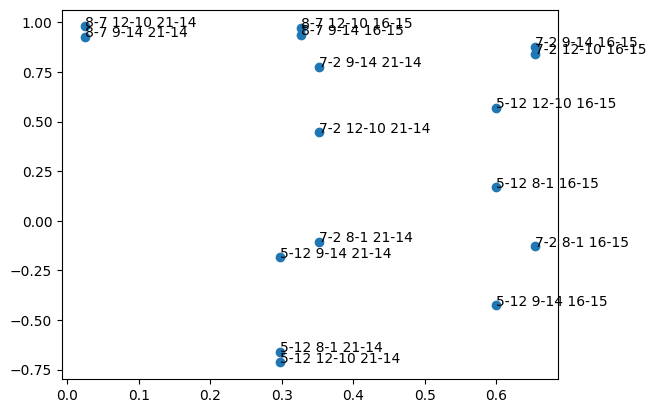

In [174]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0,1,2], k_shot=k_shot)

In [202]:
print(key); node = add_node_to_result(result, topi=[0,1,2], label_type='argmax_attn_labels')  # head_attr_fn=get_head_mlp_attr

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
                 ┌[0] top[1, 2] 16-15,21-14 argmax_attn_labels┐
                 │                                            └[1] top[0, 1] 8-1,12-10┐
                 │                                                                    └*[2] top[0, 1, 2] 6-10,5-12,8-7...
 [-1] root labels┤
                 └[0] top[0] 20-5 argmax_attn_labels┐
                                                    └[1] top[0, 1] 12-10,8-1┐
                                                                            └[2] top[0, 1, 2] 6-10,5-12,8-7


[[(5, 12, -1.402), (8, 7, -0.846)], [(12, 10, -2.067), (8, 1, -1.974)], [(20, 5, -1.164)]]


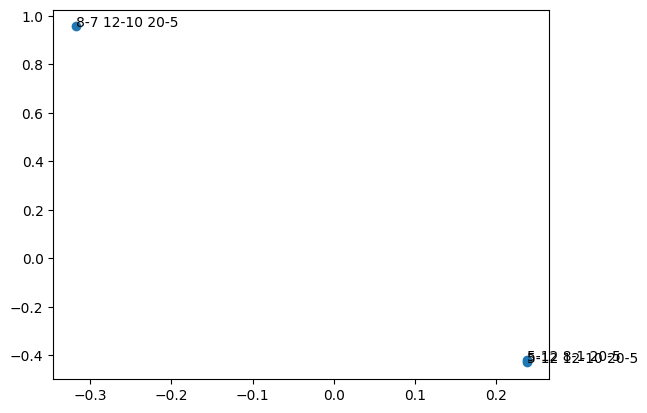

[(((5, 12), (12, 10), (20, 5)), -0.42940863966941833, 0.23799992),
 (((5, 12), (8, 1), (20, 5)), -0.4207330048084259, 0.23799992),
 (((8, 7), (12, 10), (20, 5)), 0.9564396142959595, -0.31800002)]

In [207]:
analyze_head_chains(model, get_head2scores(result.root.children[1].children[0].children[0]))

### did->does

In [20]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0): 0.613, 0.65625
MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=1): 0.650, 0.53125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0): 0.056, 0.8125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=1): 0.596, 0.5625
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0): 1.258, 0.53125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=1): 1.894, 0.5


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0,1], head_attr_fn=get_head_mlp_attr, mix=True)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    show_predictions(tokenizer, *args, logits=o.logits, labels=labels, k_shot=k_shot, topk=3)[0]

In [ ]:
result.node = result.node.parent.parent.parent
result.node = result.root

In [80]:
print(key); node = add_node_to_result(result, topi=[1,0,2,7], head_attr_fn=get_head_mlp_attr, label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr

MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)
                 ┌[0] top3 21-16 labels┐
                 │                     └[1] top[0, 1, 2, 3, 4, 5] 19-16,8-16,13-13,17-16,7-16,6-16
                 ├[0] top[0] 17-9 attn_labels┐
                 │                           └[1] top[0, 1, 2] 12-10,8-1,13-13┐
                 │                                                            └[2] top[0] 6-10
 [-1] root labels┤
                 │                     ┌[1] top[0, 1, 2, 3, 4, 5] 18-16,13-13,14-7,16-16,12-10,17-16
                 ├[0] top0 19-16 labels┤
                 │                     └[1] top0 18-16┐
                 │                                    └[2] top0 17-16┐
                 │                                                   └[3] top[0, 1] 16-16,15-16
                 └[0] top[1] 14-7 attn_labels┐
                                             └[1] top[0, 1] 8-1,12-10┐
                                                          

In [ ]:
for data_tuple in data_tuples:
    plot_attn_attr(data_tuple, model, tokenizer, node, 17, 16, attn_patterns=None, k_shot=0, plot_attr=False)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node.parent, topi=[0,1,6,7,10])

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=10)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 7], head_attr_fn=get_head_mlp_attr)

In [89]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3])

MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1, 2, 3, 4] 9-14,13-13,15-5,8-1,12-10┐
                                                                                              └*[2] top[0, 1, 2, 3] 6-10,1-7,3-12,6-2...


[[(6, 2, -0.6)], [(9, 14, -2.579), (13, 13, -2.123), (15, 5, -2.675), (8, 1, -1.939), (12, 10, -2.034)], [(16, 7, -1.086)]]


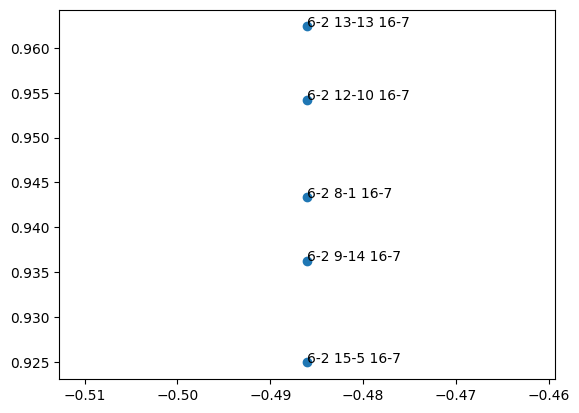

In [93]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [107]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3], label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr, 

MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top2 19-16 labels┐
                 │                     └[1] top[0, 1, 2, 3, 4, 5, 6] 13-13,18-16,0-16,17-16,16-16,13-7,12-10
 [-1] root labels┤
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1, 2, 3, 4] 9-14,8-1,13-13,15-5,12-10┐
                                                                                              └*[2] top[0, 1, 2, 3] 6-10,1-7,3-12,6-2...


### thing->capability

In [1067]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.536, 0.71875
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 1.068, 0.375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.434, 0.9375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.939, 0.59375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 2.783, 0.375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 2.983, 0.3125


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1])

In [964]:
print(key); node = add_node_to_result(result, topi=[0,1])

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)
                 ┌[0] top[0] 13-15 attn_labels┐
                 │                            └[1] top[0, 1] 8-1,12-10┐
                 │                                                    └[2] top[0, 1] 5-12,6-5
 [-1] root labels┤
                 └[0] top[3] 21-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0, 1] 3-12,5-12...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [1062]:
print(key); node = add_node_to_result(result, topi=[2,1,3,0])

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 9-14,12-10┐
                                                                      └*[2] top[2, 1, 3, 0] 8-7,1-7,6-10,3-12...


[[(8, 7, -0.282)], [(9, 14, -2.228), (12, 10, -2.236)], [(16, 7, -1.271)]]


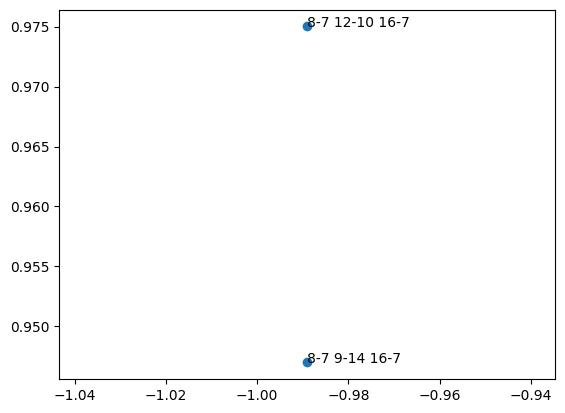

In [1063]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [988]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        tokenizer, *args, logits=o.logits, labels=labels, loss_reduction='mean',
        candidates=None, k_shot=k_shot, topk=3, verbose=True)
    print(loss)

*Ġplay 0.133 {'Ġplay': 0.133, 'Ġshoot': 0.058, 'âĢ': 0.057} 	 Justice has a piano. Chance has a gun. Justice can play
*Ġbake 0.241 {'Ġbake': 0.241, 'Ġfly': 0.136, 'Ġcook': 0.128} 	 Tyler has an oven. London has a plane. Tyler can bake
 Ġfly 0.04 {'Ġprint': 0.727, 'Ġtype': 0.046, 'Ġfly': 0.04} 	 India has a printer. Eva has a glider. Eva can fly
*Ġwash 0.606 {'Ġwash': 0.606, 'Ġdry': 0.074, 'Ġclean': 0.062} 	 Jamie has a phone. Dream has washing machine. Dream can wash
 Ġstab 0.219 {'Ġopen': 0.324, 'Ġstab': 0.219, 'Ġcut': 0.21} 	 Angel has an opener. Laura has a dagger. Laura can stab
 Ġwatch 0.0 {'Ġstab': 0.975, 'Ġkill': 0.005, 'Ġcut': 0.002} 	 Anna has a TV. Michael has a dagger. Anna can watch
 Ġcut 0.077 {'Ġcook': 0.286, 'Ġsaw': 0.119, 'Ġchop': 0.082} 	 King has a saw. Amy has a pot. King can cut
 Ġcook 0.075 {'Ġdrive': 0.37, 'Ġcook': 0.075, 'Ġfix': 0.045} 	 Georgia has a pot. Thomas has a car. Georgia can cook
3.0769495964050293
 Ġchop 0.063 {"'t": 0.073, 'âĢ': 0.069, 'Ġchop': 0.063

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0], k_shot=k_shot)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2, 3], k_shot=k_shot, plot_attr=False)

In [1047]:
print(key); node = add_node_to_result(result, topi=[1,2,0], label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
                 ┌[0] top[1] 21-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └*[2] top[1, 2, 0] 5-12,1-7,3-12...
 [-1] root labels┤
                 └[0] top[0] 13-15 argmax_attn_labels┐
                                                     └[1] top[0, 1] 8-1,12-10┐
                                                                             └[2] top[2, 3, 1, 0] 6-5,3-7,5-12,3-12


### capital->country

In [470]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=1, abstract=0): 0.068, 0.8125
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=1, abstract=1): 0.111, 0.84375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0): 0.866, 0.65625
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=1): 1.251, 0.5
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0): 0.093, 0.84375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=1): 0.119, 0.8125
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0): 1.386, 0.4375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=1): 2.561, 0.4375


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [843]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

16 0
(0.9464224576950073, 0.9693313837051392)
Berlin->['Germany'] {'ĠBerlin': 34, 'ĠFriedrich': 22, 'ĠGermany': 19, 'ĠReich': 19, 'ĠGerman': 19}
Cairo->['Egypt'] {'ĠCairo': 40, 'Egypt': 39, 'ĠEgypt': 39, 'ĠEgyptian': 38, 'ĠEgyptians': 37}
Ankara->['Turkey'] {'ĠAnkara': 42, 'ĠTurkish': 38, 'ĠErdogan': 37, 'ĠTurkey': 36, 'Turkish': 35}
Athens->['Greece'] {'ĠAthens': 42, 'ĠAthen': 33, 'ĠAthena': 30, 'ĠGreece': 30, 'ĠGreek': 29}
London->['England'] {'ĠLondon': 26, 'London': 26, 'ĠNotting': 25, 'ĠThames': 24, 'ĠBarcl': 19}
Manila->['the Philippines'] {'ĠManila': 34, 'ĠFilipino': 31, 'ĠPhilippines': 31, 'ĠPhilippine': 29, 'ĠFilip': 27}
Ottawa->['Canada'] {'ĠOttawa': 36, 'Ott': 26, 'ĠCanadians': 24, 'ĠCanadian': 24, 'ĠQuebec': 22}
Bern->['Switzerland'] {'Bern': 30, 'ĠBernstein': 30, 'ĠBern': 25, 'bern': 24, 'ĠBernard': 21}
Seoul->['South Korea'] {'ĠSeoul': 39, 'ĠKoreans': 36, 'ĠKorean': 36, 'ĠKorea': 33, 'ĠYong': 29}
Lisbon->['Portugal'] {'ĠLisbon': 40, 'ĠPortuguese': 38, 'ĠPortugal': 37, 'ĠP

In [875]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[2] 19-12 attn_labels┐
                                              └[1] top[0, 1, 2, 3] 13-13,8-1,12-10,11-0┐
                                                                                       └*[2] top[0] 5-12...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [880]:
print(key); node = add_node_to_result(result, topi=[0,1])

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0, 1] 16-0,16-7 attn_labels┐
                                                     └[1] top[0, 1, 2] 8-1,13-13,12-10┐
                                                                                      └*[2] top[0, 1] 6-2,1-7...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [677]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 16-0,12-7,19-12 attn_labels┐
                 │                                            └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                 │                                                                                             └[2] top[0, 1, 3] 5-12,3-12,1-7
 [-1] root labels┤
                 └[0] top[0, 1, 3] 16-0,12-7,19-12 argmax_attn_labels┐
                                                                     └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                                                                                                                      └*[2] top[0, 1, 2] 5-12,1-7,3-12...


### person_adjs.opposite

In [343]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=0): 0.027, 0.9375
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=1): 0.102, 0.90625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0): 1.261, 0.5625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=1): 1.538, 0.46875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0): 0.451, 0.625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=1): 0.349, 0.75
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0): 3.566, 0.3125
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=1): 3.773, 0.25


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [370]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [385]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 12-10,8-1┐
                                                                     └*[2] top[0, 1, 2, 3, 4] 6-2,8-7,3-12,1-7,6-10...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [412]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └[2] top[0] 7-9
 [-1] root labels┤
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


### thing->type

In [315]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=0): 0.032, 1.0
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=1): 0.117, 0.90625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.594, 0.65625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 1.354, 0.53125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.793, 0.625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.286, 0.8125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 2.174, 0.46875
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 1.824, 0.46875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=0): 0.048, 0.875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=1): 0.191, 0.90625
MlM_gen(persons

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1, 2])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [151]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0, 1, 2, 3, 4] 8-7,6-2,6-10,3-12,1-7...


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [206]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                 │                                                  └[1] top[0, 1] 8-1,12-10┐
                 │                                                                          └[2] top[0, 1, 3] 5-12,3-12,7-2
 [-1] root labels┤
                 ├[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └[1] top[0, 1] 8-1,12-10┐
                 │                                                                   └*[2] top[0, 1, 2] 5-12,3-12,7-2...
                 └[0] 11-9 attn_labels┐
                                      └[1] top[0] 8-1┐
                                                     └[2] top[0, 1] 3-12,7-2


In [ ]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [156]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B/cpu 0.4444444444444444
accuracies EleutherAI/gpt-neox-20b 0.5555555555555556
accuracies text-curie-001 0.3333333333333333
losses EleutherAI/gpt-j-6B/cpu 3.0475401878356934
losses EleutherAI/gpt-neox-20b 2.3752387364705405
losses text-curie-001 5.4890399882962955


In [129]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [47]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

 ... done 0:00:02.348918
 ... done 0:00:01.659792
 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.626 {'ĠA': 0.626, 'ĠI': 0.225, 'ĠY': 0.11} 	 Y A I -> A


 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.62

In [176]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B 0.4976851851851852
accuracies EleutherAI/gpt-neox-20b 0.5023148148148148
accuracies text-davinci-001 0.48148148148148145
accuracies text-davinci-002 0.9675925925925926
losses EleutherAI/gpt-j-6B 1.3536101162543572
losses EleutherAI/gpt-neox-20b 1.1634638377252957
losses text-davinci-001 1.687816629922939
losses text-davinci-002 0.1085046497381794


In [136]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

accuracies EleutherAI/gpt-j-6B 0.6203703703703703
accuracies EleutherAI/gpt-neox-20b 0.7083333333333334
accuracies text-curie-001 0.5879629629629629
losses EleutherAI/gpt-j-6B 1.5619440356433054
losses EleutherAI/gpt-neox-20b 1.0779137232247094
losses text-curie-001 3.1073556870623844


In [ ]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [11]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [81]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [80]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'Yes': 0.35, 'No': 0.226, 'Yeah': 0.078, 'I': 0.078, 'Y': 0.021}

In [75]:
get_prob_dist(logits.top_logprobs[-1], 5)

{'No': 0.824, 'Yes': 0.115, 'I': 0.04, 'What': 0.006, ' No': 0.003}

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])